```{contents}
:local:
:depth: 2
```

# Numerical Optimization

## Learning Objectives

By the end of this lecture, you should be able to:

- Describe the structure of non-linear regression problems and formulate appropriate loss functions.
- Use automatic differentiation to compute gradients of complex functions.
- Implement gradient descent with different stopping criteria and interpret convergence behavior.
- Apply numerical optimization tools (e.g., `scipy.optimize.minimize`) to fit models to data.
- Understand soft vs. hard constraints and when to use them in optimization problems.

In this lecture we will continue to work with the ethanol peaks dataset and look at numerical optimization from the perspective of non-linear regression.

First, we can re-load the dataset and select the same region we were working on before:

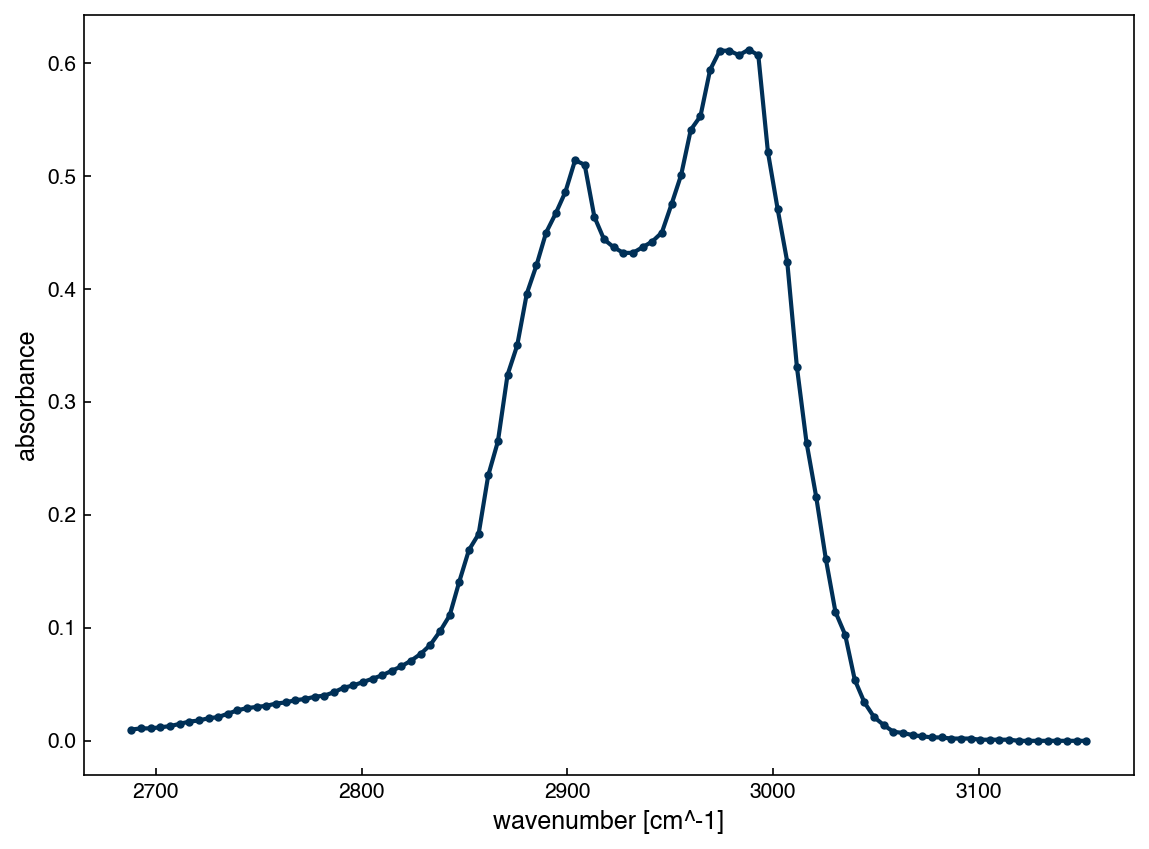

In [1]:
%matplotlib inline
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('../settings/plot_style.mplstyle')

df = pd.read_csv('data/ethanol_IR.csv')
x_all = df['wavenumber [cm^-1]'].values
y_all = df['absorbance'].values

x_peak = x_all[475:575]
y_peak = y_all[475:575]

fig, ax = plt.subplots()
ax.plot(x_peak,y_peak, '-', marker='.')
ax.set_xlabel('wavenumber [cm^-1]')
ax.set_ylabel('absorbance');

## Non-linear Regression

In the prior lecture we considered "general linear models" that followed the form:

$y_i = \sum_j w_j X_{ij} + \epsilon_i$

and all non-linear behavior has been captured by using non-linear transforms of $x_i$. However, in some cases we may want to optimize models that are not linear. For example, consider the Gaussian peak problem:

$y_i = w_0 \exp\left(-\frac{(x_i-\mu_0)^2}{2(\sigma_0^2)}\right) + w_1 \exp\left(-\frac{(x_i-\mu_1)^2}{2(\sigma_1^2)}\right) + \epsilon_i$

Previously we just guessed values for $\mu_i$ and $\sigma_i$. However, it would be better if we could determine them from the data. Let's go back to the derivation of the linear regression equations. Remember that our goal is to minimize the sum of squared errors:

$g = \sum_i \epsilon_i^2$

We can solve for $\epsilon_i$ from the model:

$\epsilon_i = y_i - w_0 \exp\left(-\frac{(x_i-\mu_0)^2}{2(\sigma_0^2)}\right) - w_1 \exp\left(-\frac{(x_i-\mu_1)^2}{2(\sigma_1^2)}\right) = y_i - \sum_j w_j G(x_i, \mu_j, \sigma_j)$

where $G(x_i, \mu_j, \sigma_j) = \exp\left(-\frac{(x_i-\mu_j)^2}{2(\sigma_j^2)}\right)$.

and substitute:

$g = \sum_i (y_i - \sum_j w_j G(x_i, \mu_j, \sigma_j))^2$

Now our loss function depends on all the parameters, $w_j$, $\mu_j$, and $\sigma_j$!

$g(w_j, \mu_j, \sigma_j) = \sum_i (y_i - \sum_j w_j G(x_i, \mu_j, \sigma_j))^2$

Let's introduce a new vector, $\vec{\lambda}$, that is a vector containing all the parameters:

$\vec{\lambda} = [\vec{w},\; \vec{\mu},\; \vec{\sigma}]$

We can do this since $\lambda_{i\leq m}$ contains the weights, $\lambda_{m < i \leq 2m}$ contains the means, and $\lambda_{i > 2m}$ contains the standard deviations. This is convenient since we can now write:

$g(\lambda_j) = \sum_{i=0}^m (y_i - \sum_j \lambda_j G(x_i, \lambda_{m+j}, \lambda_{2m+j}))^2$

and we can minimize the loss by setting the derivative equal to zero:

$\frac{\partial g}{\partial \lambda_j} = 0$

This may look scary, but we are actually just using multivariate calculus exactly like we did for linear regression. However, we are stuck with two new problems:

(1) Getting the derivative $\frac{\partial g}{\partial \lambda_j}$ will be very complicated.

(2) We need a way to find the point where $\frac{\partial g}{\partial \lambda_j}=0$.

In the case of linear regression, we derived this with matrix algebra then solved the resulting equations but that will be much more difficult in this case, and will not be general to other non-linear forms. Instead, we will use numerical methods this time around.

First, we need to implement our loss function, $g$, which we will call `gaussian_loss` since it results from a sum of $m$ Gaussians:

In [2]:
import numpy as np

def gaussian_loss(lamda, x, y, m=2):
    yhat = np.zeros(len(y))
    for i in range(m):
        w_i = lamda[i]
        mu_i = lamda[m+i]
        sigma_i = lamda[2*m+i]
        yhat = yhat + w_i*np.exp(-(x - mu_i)**2/(2*sigma_i**2))
    squared_error = (y - yhat)**2
    return np.sum(squared_error)/len(y)

Let's do a sanity check by generating some data and testing the loss function:

In [3]:
x = np.linspace(-1,1,20)
y = 0.3*np.exp((-(x-0.2)**2)/(2*(0.5**2))) #create a Gaussian with w=0.3, mu=0.2, sigma=0.5
y = y + 0.7*np.exp(-(x-0.5)**2/(2*0.1**2)) #add a Gaussian with w=0.7, mu=0.5, sigma=0.1
lamda = [0.3, 0.7, 0.2, 0.5, 0.5, 0.1] #create a "lamda" vector that should result in the same dataset
test_loss = gaussian_loss(lamda, x, y, m=2)
test_loss

np.float64(0.0)

```{admonition} Exercise
:class: tip

Try changing the number of peaks (`m=2`) in the `gaussian_loss` function to `m=3`, and create synthetic data with 3 Gaussians. Can your loss function still recover the correct loss value with the right parameters?
```


## Automatic Differentiation

Derivatives are needed a lot in machine learning. One development that has emerged from the fields of optimization and computer science is the idea of [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation), also sometimes called "algorithmic differentiation". This is crucial to the success of well-known machine learning packages like "TensorFlow". The details of how it works are far too advanced for this course, and we will not use it often. However, it is definitely worth knowing about since many engineering applications also require derivatives.

The simple version is that automatic differentiation does exactly what it sounds like: it gives you the derivative of a function automatically! We do need to use some special tools to do this in Python. The `autograd` package is the simplest, since it works well with `numpy`. We also need to write our functions in a specific way so that they only take one argument.

In [4]:
! pip install autograd #<- use this block (or the command after ! in the conda prompt) to install autograd

In [5]:
import autograd.numpy as np   # autograd has its own "version" of numpy that must be used
from autograd import grad # the "grad" function provides derivatives

def g(lamda, x=x, y=y, m=2):
    return gaussian_loss(lamda, x, y, m)

diff_g = grad(g)
print(g(lamda))
print(diff_g(lamda))
diff_g

0.0
[array(0.), array(0.), array(0.), array(0.), array(0.), array(0.)]


<function autograd.wrap_util.unary_to_nary.<locals>.nary_operator.<locals>.nary_f(*args, **kwargs)>

If you are not familiar with Python, this may look very odd. Essentially we are "wrapping" the `gaussian_loss` function in a new function `g`. Unlike `gaussian_loss`, `g` only takes a single argument, `lamda`, which is the argument we want to differentiate with respect to.

It is also worth noting that the `grad` function returns a function, not a value. This will also feel odd if you are new to Python. However, it is very convenient, because now we can use the new *function* `diff_g` to compute the derivative at any arbitrary value of $\vec{\lambda}$:

In [6]:
print(diff_g(lamda))
lamda

[array(0.), array(0.), array(0.), array(0.), array(0.), array(0.)]


[0.3, 0.7, 0.2, 0.5, 0.5, 0.1]

This is another sanity check: we know that the derivative should be zero if we are already at the optimum!

Let's try with some other guess for $\lambda_j$:

In [7]:
bad_guess = [0.1, 1.0, 0.5, 0.3, 0.1, 0.4]
print(g(bad_guess))
print(diff_g(bad_guess))

0.09629971881545715
[array(0.04543042), array(0.32856694), array(-0.01728235), array(-0.09807934), array(0.08818821), array(0.39993077)]


Now we have solved the first problem: we know how to get $\frac{\partial g}{\partial \lambda_j}(\vec{\lambda})$. However, we do not have an analytical form (i.e. we can't write it down), so we still don't know how to solve for $\frac{\partial g}{\partial \lambda_j} = 0$.

```{note}
When using Gaussian functions for regression or as basis functions, it's important to remember that the gradient of a Gaussian decays rapidly as the input moves away from the mean. This can lead to **vanishing gradients**, especially if the input values are large (e.g., wavenumbers in the 1000–4000 cm⁻¹ range).

In practical terms, this means that for parameters corresponding to Gaussians far from the data, the gradient may be close to zero — even when the model is poor — because the loss function is nearly flat in that region. This can make optimization very difficult unless the parameters are initialized near reasonable values. It's one of the reasons we often need good initial guesses or parameter constraints when fitting spectra with Gaussians.
```

In [8]:
vanish_guess = [0.1, 1.0, 100., 200., 0.1, 0.4] #make peaks very far away
print(g(vanish_guess))
print(diff_g(vanish_guess))

0.12008232596390747
[array(0.), array(0.), array(0.), array(0.), array(0.), array(0.)]


```{note}
Also note that to enable automatic differentiation, all the inputs need to be "floats", not "integers". Try removing the decimal from 100 and 200 above and see what happens.
```

```{admonition} Exercise
:class: tip

Modify the `g` function so that it only includes **one** Gaussian (`m=1`). Generate synthetic data with a single peak centered at `μ = 0.3`, with `σ = 0.05`.

Now define two guesses for `lamda`:
- A **good guess** with parameters near the true values.
- A **bad guess** where the Gaussian is centered far from the data (e.g. `μ = 2.0`).

Compute and compare the values of `g(lamda)` and `diff_g(lamda)` for both. 

**What do you observe?** This illustrates the **vanishing gradient problem**: when the Gaussian is too far from the data, the loss function becomes very flat and the gradient approaches zero, even if the model is very poor.
```


## Gradient Descent

There are many numerical techniques for solving the problem of finding $\vec{\lambda}^*$ such that $\frac{\partial g}{\partial \lambda_j}(\vec{\lambda}^*) = 0$. The two basic approaches, which should be familiar, are:

* Newton's method: Treat this as a root finding problem and use the second derivative, $\frac{\partial^2 g}{\partial \lambda_j \partial \lambda_k}$ to iteratively optimize.

* Gradient descent/ascent: Increase or decrease the guess by "walking" along the gradient.

These are typically "iterative" methods, which means we start with some initial guess then iteratively improve it.

The simplest approach is to use gradient descent with a fixed step size, which we will explore here:

In [9]:
better_guess = [0.35, 0.75, 0.21, 0.52, 0.53, 0.11]
guess = bad_guess
print('Initial Loss: {:.4f}'.format(g(guess)))

N_iter = 1000
h = 0.1
for i in range(N_iter):
    guess = guess - h*np.array(diff_g(guess))

print('Final Loss: {:.4f}'.format(g(guess)))

Initial Loss: 0.0963
Final Loss: 0.0000


We can see that the loss decreases after 1000 iterations of gradient descent. Let's compare the results:

Original Parameters: [0.3, 0.7, 0.2, 0.5, 0.5, 0.1]
Recovered Parameters: [0.69639616 0.30146582 0.49997652 0.20386904 0.09978107 0.49952471]


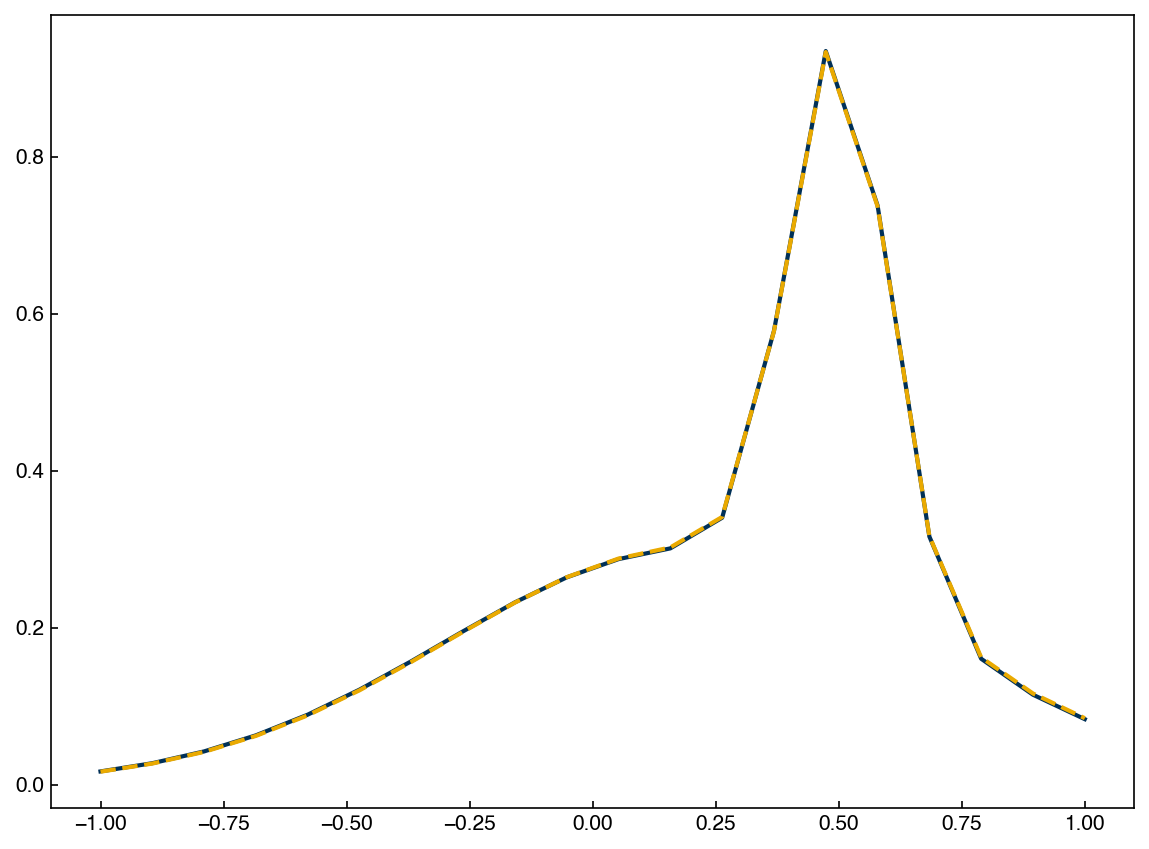

In [10]:
print('Original Parameters: {}'.format(str(lamda)))
print('Recovered Parameters: {}'.format(str(guess)))

def two_gaussians(lamda, x):
    w_0, w_1, mu_0, mu_1, sigma_0, sigma_1 = lamda
    y = w_0*np.exp((-(x-mu_0)**2)/(2*(sigma_0**2))) + w_1*np.exp(-(x-mu_1)**2/(2*sigma_1**2))
    return y

y = two_gaussians(lamda, x)
yhat = two_gaussians(guess, x)

fig, ax = plt.subplots()
ax.plot(x, y)
ax.plot(x, yhat, ls='--');

We see that this looks pretty good! The parameters look different, but it turns out that they are pretty close if you switch the order of the two peaks.

### Stopping Criteria

In real applications, we often use a **stopping criterion** to decide when to terminate an optimization loop. Common stopping conditions include:

- **Fixed number of iterations**: simple and guarantees termination, but may be inefficient or stop prematurely.
- **Tolerance on parameters**: stop when the change in parameters is small:

  ```python
  np.linalg.norm(new_guess - guess) < tol_x
  ```
- **Tolerance on loss value**: stop when the change in loss is small:

  ```python
  abs(g(new_guess) - g(guess)) < tol_y
  ```

In most cases, you will want to use a combination of these conditions to avoid infinite loops and to balance speed vs. accuracy, and choosing tolerances is problem-dependent:

- For ill-scaled problems, small changes in $\vec{\lambda}$ might yield large changes in loss.
- For flat landscapes (e.g., vanishing gradients), changes in loss may be negligible for many steps.

It’s also common to set a **maximum number of iterations** as a fallback, even if using convergence-based criteria.

```{note}
In machine learning contexts, a full loop over the dataset is often called an **epoch**. If batch gradient descent is used, then the number of epochs is equivalent to the number of iterations. In stochastic or minibatch gradient descent, one epoch may involve many updates. Regardless of terminology, the same types of stopping criteria (loss tolerance, parameter change, or number of passes) apply.
```

There are many improved versions of gradient descent used in practice, especially in machine learning. These include:

- **Stochastic Gradient Descent (SGD)**: only a random subset of the data is used at each step, which reduces computational cost and introduces randomness that can help escape local minima.

- **Momentum-based methods**: such as classical momentum or Nesterov Accelerated Gradient (NAG), which incorporate information about previous steps to accelerate learning.

- **Adam optimizer**: combines momentum and adaptive learning rates; it is the default in many deep learning libraries.

Although we will not use these in this course, it is important to know that basic gradient descent forms the foundation of all these advanced methods.

```{note}
The behavior of gradient descent is highly sensitive to:

- The initial guess: poor starting values may lead to slow convergence or incorrect minima.
- The number of steps: too few steps may not allow convergence.
- The step size (`h`): too large can overshoot or diverge; too small may converge too slowly.

For most real problems, it’s best to use a tested optimization library rather than tuning these manually.
```

```{admonition} Exercise
:class: tip

Try changing the step size `h` in the gradient descent loop to different values like `0.01`, `0.5`, and `1.0`. How does this affect convergence? Also try initializing `guess` with very bad values. What happens to the final loss?
```


## Optimization with Scipy

The `scipy` package is another commonly-used package that comes with lots of algorithms. In particular, there are a number of numerical optimization algorithms available through the `scipy.optimize.minimize` function. In practice, we will typically rely on `scipy.minimize` to handle minimization rather than writing our own algorithms. These algorithms will be more efficient, and have built-in techniques for estimating derivatives (or manage to optimize without derivatives at all).

One of the most commonly-used algorithms is the ["BFGS" algorithm](https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm), named after its creators Broyden, Fletcher, Goldfarb, and Shanno. When in doubt, this is a good algorithm to try first. Let's see how it works for our problem:

In [11]:
from  scipy.optimize  import minimize

result = minimize(g, bad_guess, method='BFGS')
result

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 4.535847841346485e-13
        x: [ 7.000e-01  3.000e-01  5.000e-01  2.000e-01  1.000e-01
             5.000e-01]
      nit: 28
      jac: [-1.508e-07  2.820e-08 -8.943e-07 -3.180e-07 -6.586e-07
             7.751e-08]
 hess_inv: [[ 1.086e+01 -2.311e+00 ... -1.207e-01  1.951e-01]
            [-2.311e+00  3.484e+00 ... -5.994e-01 -2.638e+00]
            ...
            [-1.207e-01 -5.994e-01 ...  3.661e-01  2.177e-02]
            [ 1.951e-01 -2.638e+00 ...  2.177e-02  9.058e+00]]
     nfev: 217
     njev: 31

A few things to note here:

* We still had to use the function `g` that only takes a single argument (the variable we want to optimize with respect to).
* The output is not a single number, but rather a Python class with various attributes.
* This was really fast!

We can investigate the attributes of the output using the `dir` function:

In [12]:
dir(result)

['fun',
 'hess_inv',
 'jac',
 'message',
 'nfev',
 'nit',
 'njev',
 'status',
 'success',
 'x']

Now we can check various aspects of the result using the `.` operator:

In [13]:
result.success

True

In [14]:
result.x

array([0.69999993, 0.29999964, 0.49999979, 0.19999771, 0.1000001 ,
       0.50000067])

This tells us that the optimization was successful, and gives us the final result. Let's compare this to the original input:

In [15]:
print('Actual Input: {}'.format(str(result.x)))
print('Regression Result: {}'.format(str(lamda)))

Actual Input: [0.69999993 0.29999964 0.49999979 0.19999771 0.1000001  0.50000067]
Regression Result: [0.3, 0.7, 0.2, 0.5, 0.5, 0.1]


We can see that this was much faster than our naive gradient descent, and is also more accurate (although the order of the peaks is still switched due to the bad initial guess).

Let's revisit the real spectra we worked with earlier and try to optimize the peak positions and widths:

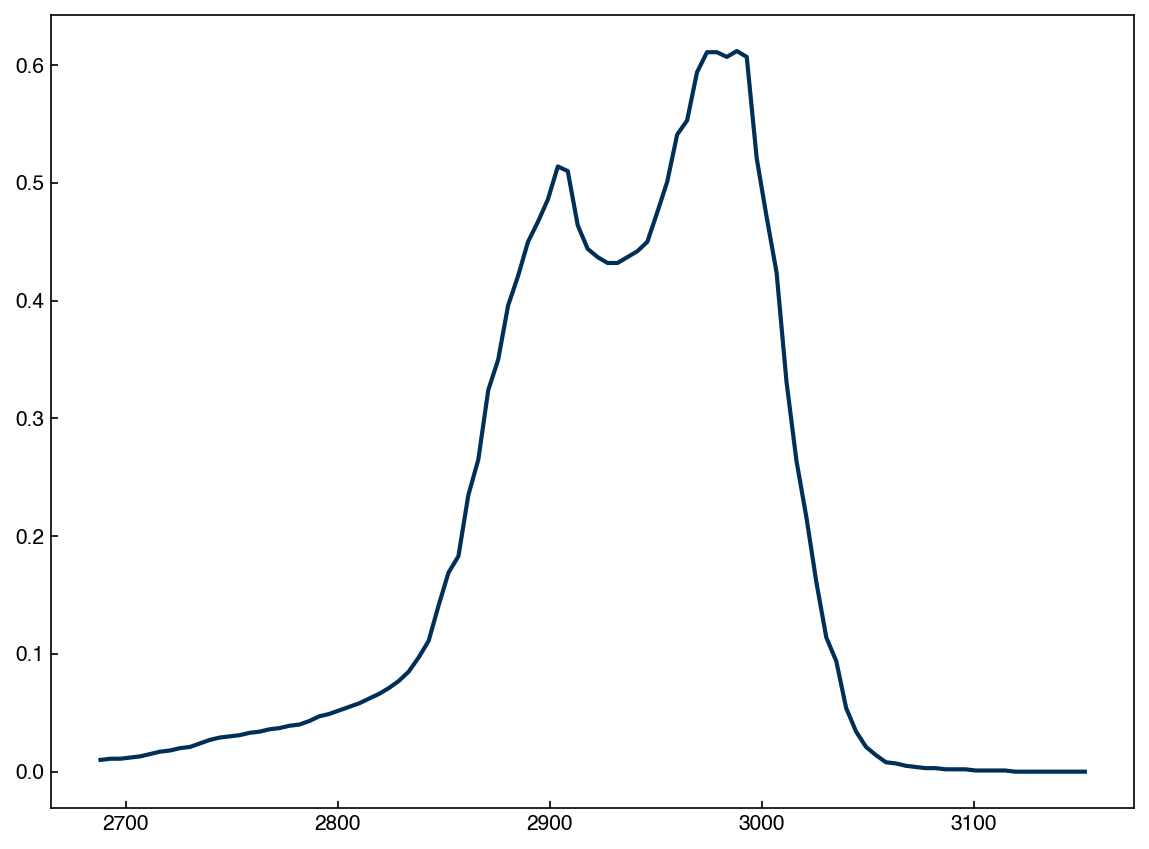

In [16]:
fig, ax = plt.subplots()
ax.plot(x_peak, y_peak);

Remember that we used guesses of the peak position and width:

$y_i = w_0 \exp\left(-\frac{(x_i-2900)^2}{2(25^2)}\right) + w_1 \exp\left(-\frac{(x_i-2980)^2}{2(25^2)}\right)$

Then we optimized the parameters, $\vec{w}$, and found $w_0 = 0.545$ and $w_1 = 0.675$. We can convert these parameters into the $\vec{\lambda}$ format and use our `two_gaussians` function to check the initial guess:

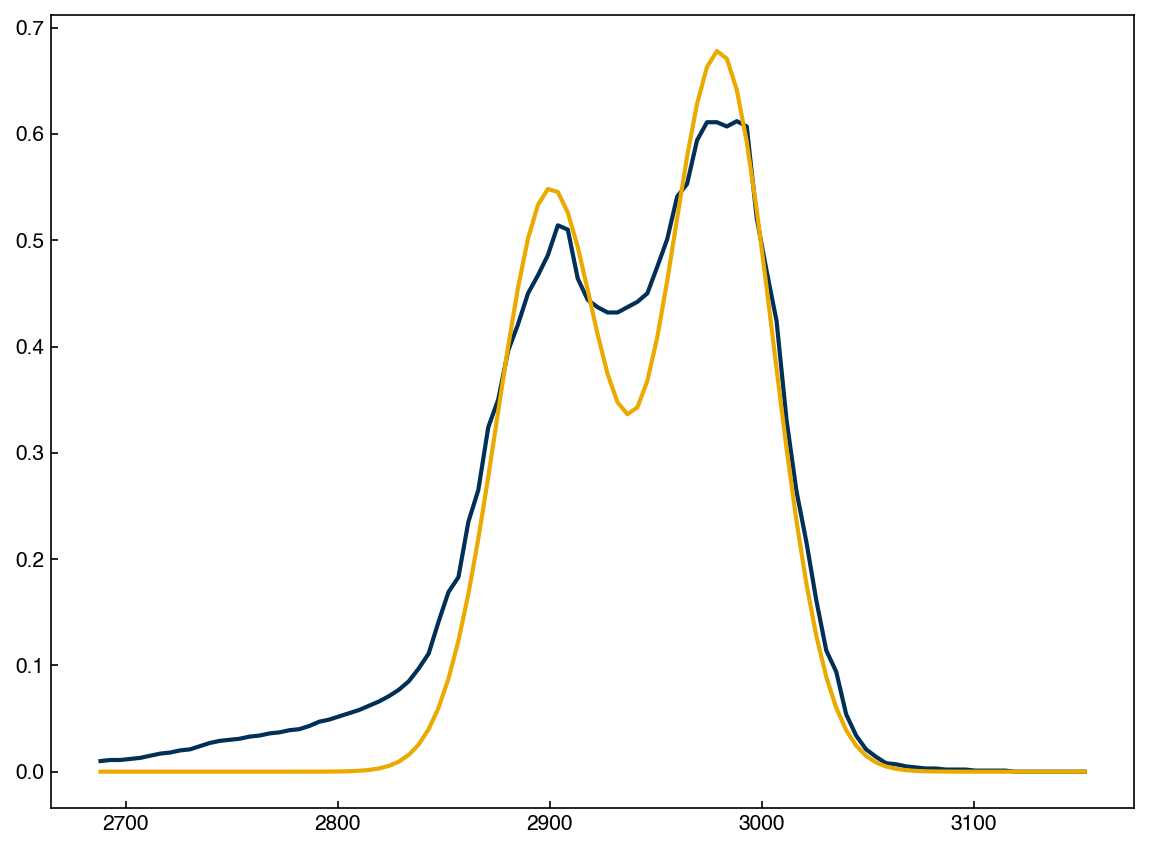

In [17]:
guess = [0.545, 0.675, 2900, 2980, 25, 25]
y_guess = two_gaussians(guess, x_peak)

fig, ax = plt.subplots()
ax.plot(x_peak, y_peak)
ax.plot(x_peak, y_guess);

Visualizing the initial guess is a good idea whenever possible (e.g. when fitting spectra), since it ensures that you are starting from a resonable point. We can use the same loss function as before to optimize the other parameters:

In [18]:
def g(lamda, x=x_peak, y=y_peak, m=2):
    return gaussian_loss(lamda, x, y, m)

result = minimize(g, guess, method='BFGS')
result

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.0003472560732986476
        x: [ 4.763e-01  5.649e-01  2.905e+03  2.985e+03  3.882e+01
             2.539e+01]
      nit: 79
      jac: [ 3.424e-06 -2.041e-07 -7.025e-09 -9.839e-08  1.010e-07
             5.166e-09]
 hess_inv: [[ 7.061e+00  1.320e+00 ... -2.407e+02 -1.888e+02]
            [ 1.320e+00  2.625e+01 ... -2.123e+03  5.054e+02]
            ...
            [-2.407e+02 -2.123e+03 ...  2.488e+05 -7.838e+04]
            [-1.888e+02  5.054e+02 ... -7.838e+04  5.666e+04]]
     nfev: 588
     njev: 84

It looks successful! Let's see how well it worked:

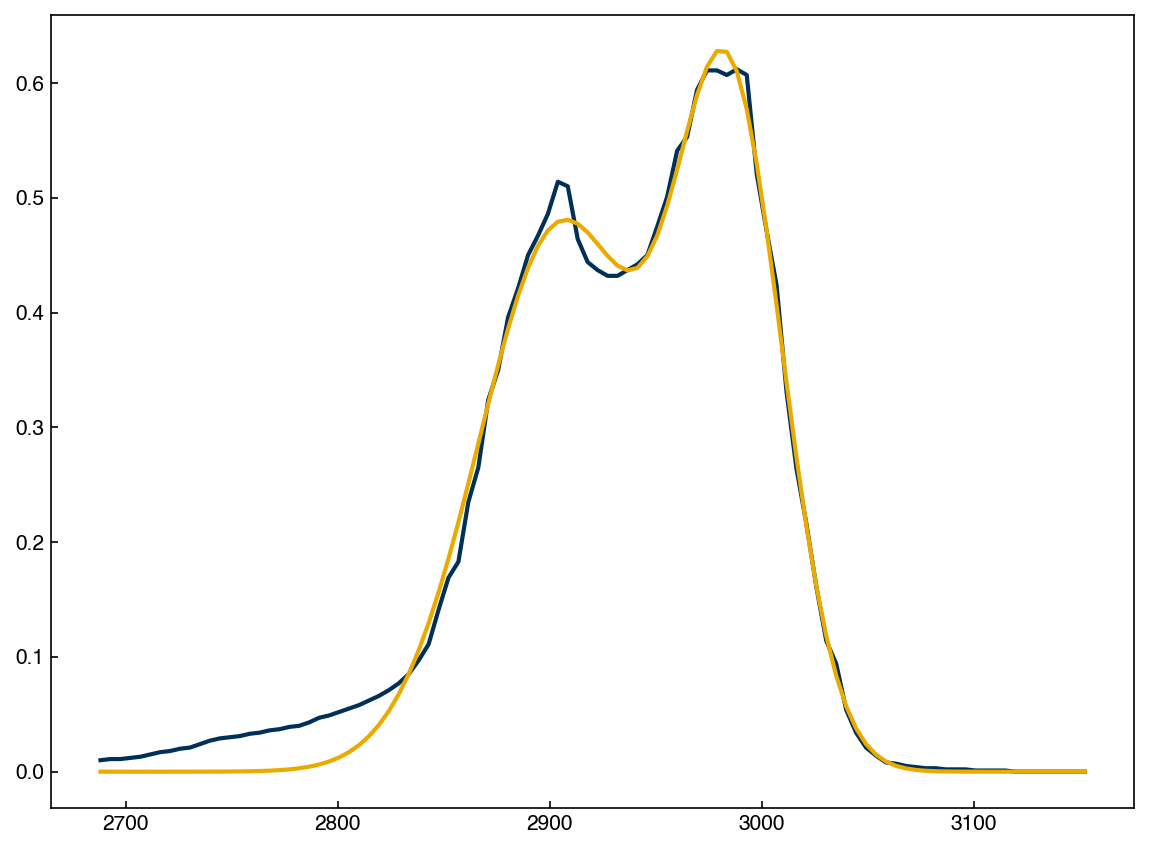

In [19]:
fitted = result.x
y_fitted = two_gaussians(fitted, x_peak)

fig, ax = plt.subplots()
ax.plot(x_peak, y_peak)
ax.plot(x_peak, y_fitted);

This looks much better!

We can also add constraints to the loss function. For example, we might expect that the peak width (standard deviation) should be similar for both peaks. We can enforce this by adding an additional term to the loss function:

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 0.0016853103771842987
        x: [ 5.450e-01  6.750e-01  2.900e+03  2.980e+03  2.500e+01
             2.500e+01]
      nit: 0
      jac: [-9.752e-05 -7.127e-05 -3.202e-05  5.509e-05  9.997e-01
             9.997e-01]
 hess_inv: [[1 0 ... 0 0]
            [0 1 ... 0 0]
            ...
            [0 0 ... 1 0]
            [0 0 ... 0 1]]
     nfev: 194
     njev: 26

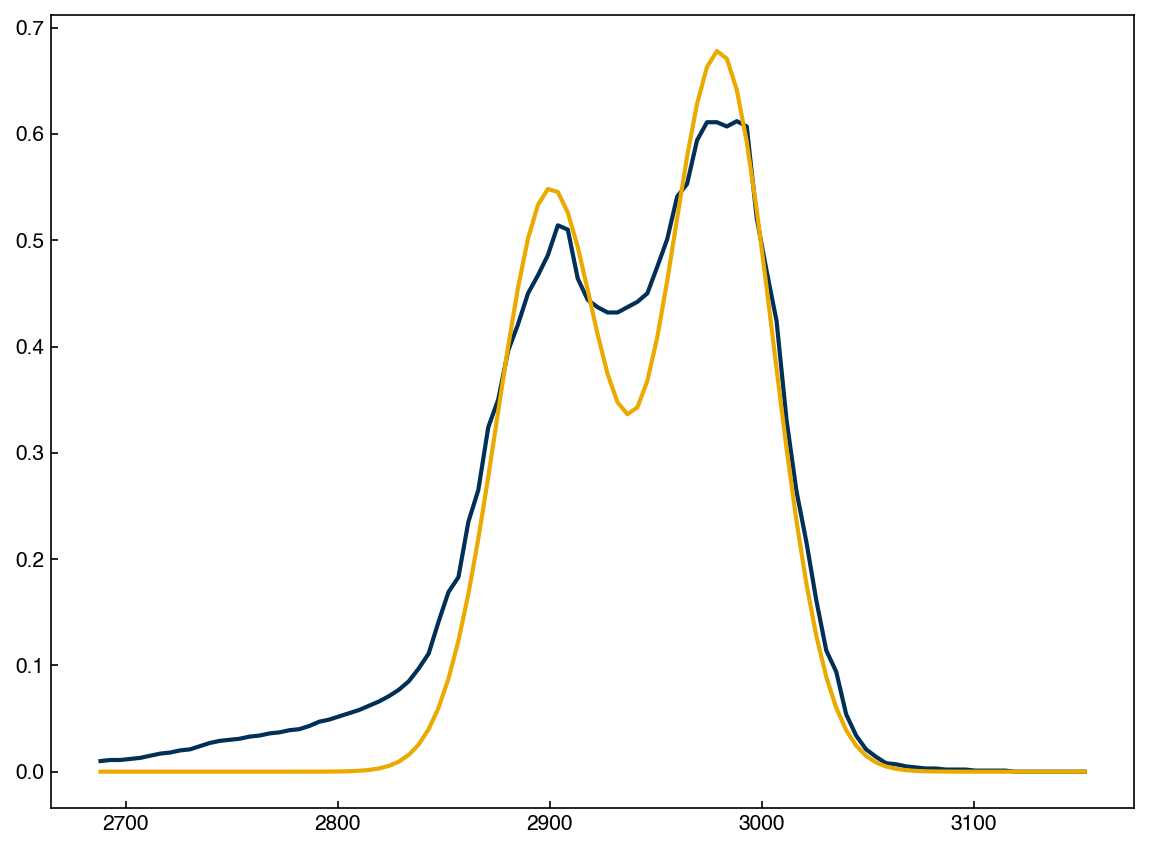

In [20]:
def g_simwidth(lamda, x=x_peak, y=y_peak, N=2):
    return gaussian_loss(lamda, x, y, N) + np.sqrt((lamda[-2] - lamda[-1])**2)

result = minimize(g_simwidth, guess, method='BFGS')
fitted = result.x
y_fitted = two_gaussians(fitted, x_peak)

fig, ax = plt.subplots()
ax.plot(x_peak, y_peak)
ax.plot(x_peak, y_fitted);
result

We can see that the fit quality is similar, but now the peak widths are nearly identical. However, they are not exactly the same, since the loss function constraint is "soft" -- the peak widths will deviate if it makes the fit much better.

~~~{note}
Sometimes we want to enforce that all parameters meet physical constraints — for example, that all weights $w_i$ are positive.

One common approach is to modify the loss function to penalize violations of the constraint. For instance, you could add a differentiable penalty term like:

```python
penalty = np.sqrt(np.sum([max(0, -w)**2 for w in lamda[:m]]))
```

to the loss function. This discourages negative weights but does not absolutely prevent them. These are known as **soft constraints**.

Alternatively, many optimizers (including `scipy.minimize`) support **bounds** or **constraints** that can enforce this behavior exactly. These are called **hard constraints**.
~~~

```{admonition} Exercise
:class: tip

Modify the Gaussian loss function to include a soft constraint that penalizes negative weights using a root-mean-square penalty. What happens to the fit when the initial guess includes a negative weight? Try different values of the penalty term’s weight to control the strength of the constraint.
```


## Additional Reading

- [SciPy Optimize Documentation](https://docs.scipy.org/doc/scipy/reference/optimize.html)
- [Automatic Differentiation – Wikipedia](https://en.wikipedia.org/wiki/Automatic_differentiation)
- [Nocedal and Wright, *Numerical Optimization*](https://link.springer.com/book/10.1007/978-0-387-40065-5)
- [Understanding the Adam Optimizer](https://arxiv.org/abs/1412.6980)